In [82]:
import pandas as pd
import numpy as np
import os
#import data
from biom import load_table
from gneiss.util import match
#deicode
from deicode.optspace import OptSpace
from deicode.preprocessing import rclr
from deicode.ratios import log_ratios
#skbio
import warnings; warnings.simplefilter('ignore') #for PCoA warning
from skbio import DistanceMatrix
from skbio.stats.ordination import pcoa
from scipy.stats import pearsonr
from matplotlib import cm
from skbio.stats.ordination import OrdinationResults
from skbio.stats.composition import clr,centralize
#plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib import ticker
import matplotlib.colors as mcolors
plt.style.use('seaborn-paper')
paper_rc = {'lines.linewidth': 1.5}                  
sns.set_context("paper", rc = paper_rc)  
plt.rcParams["axes.labelsize"] = 25
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25


def plot_pcoa(samples, var, md, ax, factor_, colors_map):
    """ 
    Parameters
    ----------
    samples : pd.DataFrame
        Contains PCoA coordinates
    md : pd.Dataframe
        Metadata object
    ax : matplotlib.Axes
        Contains matplotlib axes object
    """
    classes=np.sort(list(set(md[factor_].values)))
    cmap_out={}
    for sub_class,color_ in zip(classes,colors_map):
        idx = md[factor_] == sub_class        
        ax.scatter(samples.loc[idx, 'PC1'],
           samples.loc[idx, 'PC2'], 
           label=sub_class.replace('stressed','Stressed'),
           facecolors=color_,
           edgecolors=color_,
           alpha=.8,linewidth=3)        
        cmap_out[sub_class]=color_
    ax.grid()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('PC1 ('+str(var.loc['PC1','per_var'])[:2]+'%)',fontsize=15)
    ax.set_ylabel('PC2 ('+str(var.loc['PC2','per_var'])[:2]+'%)',fontsize=15)

    return ax,cmap_out

%matplotlib inline

### Case Study Benchmark Sub-sample

In [4]:
# store info
both_perm_res={}
both_perm_res['Sponges']=pd.read_csv('subsample_results/Sponges_health_status_fstat.csv', index_col=[0,1,2])
both_perm_res['Sleep_Apnea']=pd.read_csv('subsample_results/Sleep_Apnea_exposure_type_fstat.csv', index_col=[0,1,2])
both_nn={}
both_nn['Sponges']=pd.read_csv('subsample_results/Sponges_health_status_classifier.csv', index_col=[0,1,2])
both_nn['Sleep_Apnea']=pd.read_csv('subsample_results/Sleep_Apnea_exposure_type_classifier.csv', index_col=[0,1,2])
factor={}
factor['Sponges']='health_status'
factor['Sleep_Apnea']='exposure_type'

#clean up the dataframes
rename_m={'Bray_Curtis':'Bray-Curtis',
         'GUniFrac_Alpha_Half':'Generalized UniFrac $\\alpha$=0.5',
         'GUniFrac_Alpha_One':'Generalized UniFrac $\\alpha$=1.0',
         'GUniFrac_Alpha_Zero':'Generalized UniFrac $\\alpha$=0.0',
         'Jaccard':'Jaccard',
         'Robust_Aitchison':'Robust Aitchison'}
#colors to use later
colors_={'Bray-Curtis':'#1f78b4',
        'Generalized UniFrac $\\alpha$=0.5':'#e31a1c',
        'Generalized UniFrac $\\alpha$=1.0':'#984ea3',
        'Generalized UniFrac $\\alpha$=0.0':'#ff7f00',
        'Jaccard':'#e6ab02',
        'Robust Aitchison':'#33a02c'}


for dataset_,results_permanova in both_perm_res.items():
    df_ = pd.DataFrame(results_permanova.copy().stack())
    df_.reset_index(inplace=True)
    df_.columns = ['Fold','N-Samples','Metric','Method','Values']
    df_['Method'] = [rename_m[x] for x in df_.Method]
    df_=df_[df_['N-Samples']>=70]
    both_perm_res[dataset_]=df_[df_.Metric.isin(['test statistic'])]
    
for dataset_,results_nn in both_nn.items():
    df_ = pd.DataFrame(results_nn.copy().stack())
    df_.reset_index(inplace=True)
    df_.columns = ['Fold','N-Samples','Metric','Method','Values']
    df_['Method'] = [rename_m[x] for x in df_.Method]
    df_=df_[df_['N-Samples']>=70]
    both_nn[dataset_]=df_[df_.Metric.isin(['R^{2}'])]
  


# Figure 3

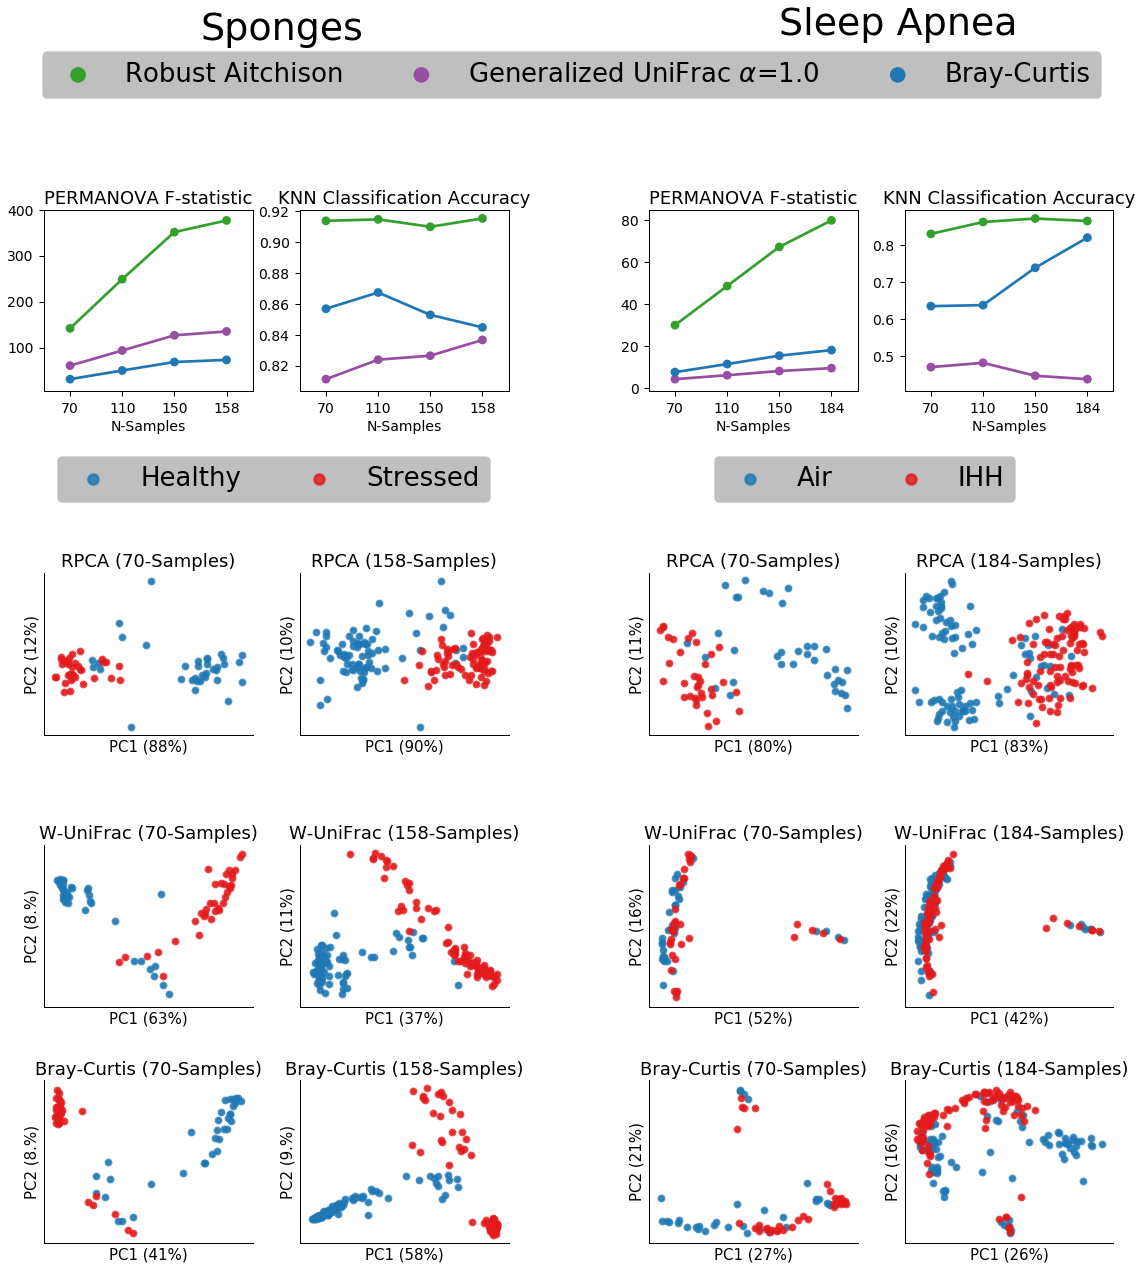

In [104]:
plt.rcParams["axes.labelsize"] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
colors_map=['#1f78b4','#e31a1c']
subpath_sp='sub_sample/biom_tables_Sponges'
subpath_sl='sub_sample/biom_tables_Sleep_Apnea'

fontsize_ = 18

fig = plt.figure(figsize=(20, 20), facecolor='white')
gs = gridspec.GridSpec(300, 240)
x_1=10+45
x_2=x_1+10
x_3=x_2+45

x_4=x_3+30
x_5=x_4+45
x_6=x_5+10
x_7=x_6+45


# benchmarking (clasification)
fstat_ax1 = plt.subplot(gs[:50, 10:x_1])
clasif_ax2 = plt.subplot(gs[:50:, x_2:x_3])
fstat_ax3 = plt.subplot(gs[:50, x_4:x_5])
clasif_ax4 = plt.subplot(gs[:50:, x_6:x_7])
# RPCA
RPCA_ax1 = plt.subplot(gs[100:145, 10:x_1])
RPCA_ax2 = plt.subplot(gs[100:145:, x_2:x_3])
RPCA_ax3 = plt.subplot(gs[100:145, x_4:x_5])
RPCA_ax4 = plt.subplot(gs[100:145:, x_6:x_7])
# WUNI
WUNI_ax1 = plt.subplot(gs[175:220, 10:x_1])
WUNI_ax2 = plt.subplot(gs[175:220:, x_2:x_3])
WUNI_ax3 = plt.subplot(gs[175:220, x_4:x_5])
WUNI_ax4 = plt.subplot(gs[175:220:, x_6:x_7])
# BC
BC_ax1 = plt.subplot(gs[240:285, 10:x_1])
BC_ax2 = plt.subplot(gs[240:285:, x_2:x_3])
BC_ax3 = plt.subplot(gs[240:285, x_4:x_5])
BC_ax4 = plt.subplot(gs[240:285:, x_6:x_7])

# plot benchmarking
fstat_ax1.set_title('PERMANOVA F-statistic', fontsize=fontsize_)
sns.pointplot(x='N-Samples',y='Values',hue='Method',
              data=both_perm_res['Sponges'].sort_values('Method',ascending=False),
              palette=colors_, ci=0, ax=fstat_ax1)
fstat_ax1.legend_.remove()

clasif_ax2.set_title('KNN Classification Accuracy', fontsize=fontsize_)
sns.pointplot(x='N-Samples',y='Values',hue='Method',
              data=both_nn['Sponges'].sort_values('Method',ascending=False),
              palette=colors_, ci=0, ax=clasif_ax2)
clasif_ax2.legend(loc=2, 
                bbox_to_anchor=(-1.3, 1.95),
                prop={'size':26},
                fancybox=True, framealpha=0.5,ncol=4
                , markerscale=2, facecolor="grey")


fstat_ax3.set_title('PERMANOVA F-statistic', fontsize=fontsize_)
sns.pointplot(x='N-Samples',y='Values',hue='Method',
              data=both_perm_res['Sleep_Apnea'].sort_values('Method',ascending=False),
              palette=colors_, ci=0, ax=fstat_ax3)
fstat_ax3.legend_.remove()


clasif_ax4.set_title('KNN Classification Accuracy', fontsize=fontsize_)
sns.pointplot(x='N-Samples',y='Values',hue='Method',
              data=both_nn['Sleep_Apnea'].sort_values('Method',ascending=False),
              palette=colors_, ci=0, ax=clasif_ax4)
clasif_ax4.legend_.remove()


fstat_ax1.set_ylabel('')
clasif_ax2.set_ylabel('')
fstat_ax3.set_ylabel('')
clasif_ax4.set_ylabel('')

# set titles for case-study 
fstat_ax1.annotate('Sponges',(2.5,770), 
                   annotation_clip=False,
                  fontsize=fontsize_+20)
fstat_ax3.annotate('Sleep Apnea',(2,168), 
                   annotation_clip=False,
                  fontsize=fontsize_+20)

# 30 samples total sponge
meta_ = pd.read_table(os.path.join(subpath_sp,'1_70','metadata.tsv'), index_col=0)
rpca_tmp = pd.read_table(os.path.join(subpath_sp,'1_70','Robust_Aitchison_Distance.tsv'), 
                       index_col=0,low_memory=False).reindex(index=meta_.index,columns=meta_.index)
rpca_tmp=pcoa(DistanceMatrix(rpca_tmp))
rpca_tmp_var = pd.DataFrame(np.around((rpca_tmp.eigvals/(rpca_tmp.eigvals.sum()))*100,0),
                            columns=['per_var']).astype(int).astype(float)
rpca_tmp = rpca_tmp.samples[['PC1','PC2']]
rpca_tmp.index=meta_.index

bc_tmp = pd.read_table(os.path.join(subpath_sp,'1_70','Bray_Distance.tsv'), 
                       index_col=0,low_memory=False).reindex(index=meta_.index,columns=meta_.index)
bc_tmp=pcoa(DistanceMatrix(bc_tmp))
bc_tmp_var = pd.DataFrame(np.around((bc_tmp.eigvals/(bc_tmp.eigvals.sum()))*100,0),
                          columns=['per_var']).astype(int).astype(float)
bc_tmp = bc_tmp.samples[['PC1','PC2']]
bc_tmp.index=meta_.index

wun_tmp = pd.read_table(os.path.join(subpath_sp,'1_70','GUniFrac_alpha_one_Distance.tsv'), 
                       index_col=0,low_memory=False).reindex(index=meta_.index,columns=meta_.index)
wun_tmp=pcoa(DistanceMatrix(wun_tmp))
wun_tmp_var = pd.DataFrame(np.around((wun_tmp.eigvals/(wun_tmp.eigvals.sum()))*100,0),
                          columns=['per_var']).astype(int).astype(float)
wun_tmp = wun_tmp.samples[['PC1','PC2']]
wun_tmp.index=meta_.index

plot_pcoa(rpca_tmp, rpca_tmp_var, meta_, RPCA_ax1, factor['Sponges'], colors_map)
plot_pcoa(wun_tmp, wun_tmp_var, meta_, WUNI_ax1, factor['Sponges'], colors_map)
plot_pcoa(bc_tmp, bc_tmp_var, meta_, BC_ax1, factor['Sponges'], colors_map)

RPCA_ax1.legend(loc=2, 
                bbox_to_anchor=(0, 1.8),
                prop={'size':26},
                fancybox=True, framealpha=0.5,ncol=2
                , markerscale=2, facecolor="grey")


RPCA_ax1.set_title('RPCA (70-Samples)', fontsize=fontsize_)
WUNI_ax1.set_title('W-UniFrac (70-Samples)', fontsize=fontsize_)
BC_ax1.set_title('Bray-Curtis (70-Samples)', fontsize=fontsize_)

# 30 samples total sleep
meta_ = pd.read_table(os.path.join(subpath_sl,'1_70','metadata.tsv'), index_col=0)
rpca_tmp = OrdinationResults.read(os.path.join(subpath_sl,'1_70','RPCA_Ordination.txt'))
rpca_tmp_var = rpca_tmp.proportion_explained
rpca_tmp_var = pd.DataFrame(rpca_tmp_var)*100
rpca_tmp_var.index = ['PC'+str(x) for x in range(1,rpca_tmp_var.shape[0]+1)]
rpca_tmp_var.columns = ['per_var']
rpca_tmp = rpca_tmp.samples
rpca_tmp.columns = ['PC2','PC1','PC3']


bc_tmp = pd.read_table(os.path.join(subpath_sl,'1_70','Bray_Distance.tsv'), 
                       index_col=0,low_memory=False).reindex(index=meta_.index,columns=meta_.index)
bc_tmp=pcoa(DistanceMatrix(bc_tmp))
bc_tmp_var = pd.DataFrame(np.around((bc_tmp.eigvals/(bc_tmp.eigvals.sum()))*100,0),
                          columns=['per_var']).astype(int).astype(float)
bc_tmp = bc_tmp.samples[['PC1','PC2']]
bc_tmp.index=meta_.index


wun_tmp = pd.read_table(os.path.join(subpath_sl,'1_70','GUniFrac_alpha_one_Distance.tsv'), 
                       index_col=0,low_memory=False).reindex(index=meta_.index,columns=meta_.index)
wun_tmp=pcoa(DistanceMatrix(wun_tmp))
wun_tmp_var = pd.DataFrame(np.around((wun_tmp.eigvals/(wun_tmp.eigvals.sum()))*100,0),
                          columns=['per_var']).astype(int).astype(float)
wun_tmp = wun_tmp.samples[['PC1','PC2']]
wun_tmp.index=meta_.index

plot_pcoa(rpca_tmp, rpca_tmp_var, meta_, RPCA_ax3, factor['Sleep_Apnea'], colors_map)
plot_pcoa(wun_tmp, wun_tmp_var, meta_, WUNI_ax3, factor['Sleep_Apnea'], colors_map)
plot_pcoa(bc_tmp, bc_tmp_var, meta_, BC_ax3, factor['Sleep_Apnea'], colors_map)


RPCA_ax3.set_title('RPCA (70-Samples)', fontsize=fontsize_)
WUNI_ax3.set_title('W-UniFrac (70-Samples)', fontsize=fontsize_)
BC_ax3.set_title('Bray-Curtis (70-Samples)', fontsize=fontsize_)

RPCA_ax3.legend(loc=2, 
                bbox_to_anchor=(0.25, 1.8),
                prop={'size':26},
                fancybox=True, framealpha=0.5,ncol=2
                , markerscale=2, facecolor="grey")

# max samp sponge 
meta_ = pd.read_table(os.path.join(subpath_sp,'1_158','metadata.tsv'), index_col=0)
rpca_tmp = pd.read_table(os.path.join(subpath_sp,'1_158','Robust_Aitchison_Distance.tsv'), 
                       index_col=0,low_memory=False).reindex(index=meta_.index,columns=meta_.index)
rpca_tmp=pcoa(DistanceMatrix(rpca_tmp))
rpca_tmp_var_sponge = pd.DataFrame(np.around((rpca_tmp.eigvals/(rpca_tmp.eigvals.sum()))*100,0),
                            columns=['per_var']).astype(int).astype(float)
rpca_tmp = rpca_tmp.samples[['PC1','PC2']]
rpca_tmp.index=meta_.index

bc_tmp = pd.read_table(os.path.join(subpath_sp,'1_158','Bray_Distance.tsv'), 
                       index_col=0,low_memory=False).reindex(index=meta_.index,columns=meta_.index)
bc_tmp=pcoa(DistanceMatrix(bc_tmp))
bc_tmp_var = pd.DataFrame(np.around((bc_tmp.eigvals/(bc_tmp.eigvals.sum()))*100,0),
                          columns=['per_var']).astype(int).astype(float)
bc_tmp = bc_tmp.samples[['PC1','PC2']]
bc_tmp.index=meta_.index


wun_tmp = pd.read_table(os.path.join(subpath_sp,'1_158','GUniFrac_alpha_one_Distance.tsv'), 
                       index_col=0,low_memory=False).reindex(index=meta_.index,columns=meta_.index)
wun_tmp=pcoa(DistanceMatrix(wun_tmp))
wun_tmp_var = pd.DataFrame(np.around((wun_tmp.eigvals/(wun_tmp.eigvals.sum()))*100,0),
                          columns=['per_var']).astype(int).astype(float)
wun_tmp = wun_tmp.samples[['PC1','PC2']]
wun_tmp.index=meta_.index

plot_pcoa(rpca_tmp, rpca_tmp_var_sponge, meta_, RPCA_ax2, factor['Sponges'], colors_map)
plot_pcoa(wun_tmp, bc_tmp_var, meta_, WUNI_ax2, factor['Sponges'], colors_map)
plot_pcoa(bc_tmp, wun_tmp_var, meta_, BC_ax2, factor['Sponges'], colors_map)

RPCA_ax2.set_title('RPCA (158-Samples)', fontsize=fontsize_)
WUNI_ax2.set_title('W-UniFrac (158-Samples)', fontsize=fontsize_)
BC_ax2.set_title('Bray-Curtis (158-Samples)', fontsize=fontsize_)


# max samp sleep 
meta_ = pd.read_table(os.path.join(subpath_sl,'1_184','metadata.tsv'), index_col=0)
rpca_tmp = OrdinationResults.read(os.path.join(subpath_sl,'1_184','RPCA_Ordination.txt'))
rpca_tmp_var_sleep = rpca_tmp.proportion_explained
rpca_tmp_var_sleep = pd.DataFrame(rpca_tmp_var_sleep)*100
rpca_tmp_var_sleep.index = ['PC'+str(x) for x in range(1,rpca_tmp_var_sleep.shape[0]+1)]
rpca_tmp_var_sleep.columns = ['per_var']
rpca_tmp = rpca_tmp.samples
rpca_tmp.columns = ['PC2','PC1','PC3']


bc_tmp = pd.read_table(os.path.join(subpath_sl,'1_184','Bray_Distance.tsv'), 
                       index_col=0,low_memory=False).reindex(index=meta_.index,columns=meta_.index)
bc_tmp=pcoa(DistanceMatrix(bc_tmp))
bc_tmp_var = pd.DataFrame(np.around((bc_tmp.eigvals/(bc_tmp.eigvals.sum()))*100,0),
                          columns=['per_var']).astype(int).astype(float)
bc_tmp = bc_tmp.samples[['PC1','PC2']]
bc_tmp.index=meta_.index

wun_tmp = pd.read_table(os.path.join(subpath_sl,'1_184','GUniFrac_alpha_one_Distance.tsv'), 
                       index_col=0,low_memory=False).reindex(index=meta_.index,columns=meta_.index)
wun_tmp=pcoa(DistanceMatrix(wun_tmp))
wun_tmp_var = pd.DataFrame(np.around((wun_tmp.eigvals/(wun_tmp.eigvals.sum()))*100,0),
                          columns=['per_var']).astype(int).astype(float)
wun_tmp = wun_tmp.samples[['PC1','PC2']]
wun_tmp.index=meta_.index

plot_pcoa(rpca_tmp, rpca_tmp_var_sleep, meta_, RPCA_ax4, factor['Sleep_Apnea'], colors_map)
plot_pcoa(wun_tmp, wun_tmp_var, meta_, WUNI_ax4, factor['Sleep_Apnea'], colors_map)
plot_pcoa(bc_tmp, bc_tmp_var, meta_, BC_ax4, factor['Sleep_Apnea'], colors_map)

RPCA_ax4.set_title('RPCA (184-Samples)', fontsize=fontsize_)
WUNI_ax4.set_title('W-UniFrac (184-Samples)', fontsize=fontsize_)
BC_ax4.set_title('Bray-Curtis (184-Samples)', fontsize=fontsize_)

fig.savefig('figures/figure4.png',dpi=300, 
            bbox_inches='tight',facecolor='white')
plt.show()


# Figure 4

In [94]:
from numpy.polynomial.polynomial import polyfit


def plot_biplot(samples, md, ax, factor_, y_axis_, x_axis, regcol,colors_map=['#1f78b4','#e31a1c']):
    """ 
    Parameters
    ----------
    samples : pd.DataFrame
        Contains PCoA coordinates
    md : pd.Dataframe
        Metadata object
    ax : matplotlib.Axes
        Contains matplotlib axes object
    """
    cmap_out={}
    classes=np.sort(list(set(md[factor_].values)))
    for sub_class,color_ in zip(classes,colors_map):
        idx = md[factor_] == sub_class
        ax.scatter(samples.loc[idx, y_axis_],
           samples.loc[idx, x_axis], 
           label=sub_class.replace('stressed','Stressed'),
           facecolors=color_,
           edgecolors=color_,
           alpha=.8,linewidth=3)   
        cmap_out[sub_class]=color_
        
        
    fit_=samples.dropna(subset=[y_axis_,x_axis])
    x=fit_.loc[:, y_axis_]
    y=fit_.loc[:, x_axis]
    # Fit with polyfit
    b, m = polyfit(x, y, 1)
    ax.plot(x, b + m * x, '-', lw=2, color=regcol, label='_nolegend_')

        
    ax.grid()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_yticks([])
    ax.xaxis.set_tick_params(labelsize=20)
    return ax,cmap_out

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


In [113]:
from biom.util import biom_open
from biom import load_table
from gneiss.util import match
from skbio.stats.ordination import OrdinationResults

lr_datasets = {}
for dataset_,sub_ in zip(['Sponges','Sleep_Apnea'],
                         ['biom_tables_Sponges/1_248','biom_tables_Sleep_Apnea/1_184']):
    lr_datasets[dataset_]={}
    
    # get table
    in_biom = 'sub_sample/'+sub_+'/table.biom'
    table = load_table(in_biom)
    table = table.to_dataframe().T
    #remove few read sotus to help lr
    table = table.T[table.sum()>50].T 

    # get ordination file
    in_ord = 'sub_sample/'+sub_+'/RPCA_Ordination.txt'
    sample_loading = OrdinationResults.read(in_ord).samples
    feat_loading = OrdinationResults.read(in_ord).features

    # taxonomy file
    tax_col = ['kingdom', 'phylum', 'class', 'order',
               'family', 'genus', 'species']
    taxon = pd.read_table('data/'+dataset_+'/taxonomy.tsv',index_col=0)
    taxon = {i:pd.Series(j) for i,j in taxon['Taxon'].str.split(';').items()}
    taxon = pd.DataFrame(taxon).T
    taxon.columns = tax_col

    # metadata
    meta = pd.read_table('sub_sample/'+sub_+'/metadata.tsv',index_col=0)

    #match em
    table,meta=match(table,meta)
    table,taxon=match(table.T,taxon)
    feat_loading,table=match(feat_loading,table)
    sample_loading,table=match(sample_loading,table.T)
    table,meta=match(table,meta)

    #sort em
    table=table.T.sort_index().T
    feat_loading=feat_loading.reindex(index=table.columns)
    taxon=taxon.reindex(index=table.columns)
    
    # relabel otus 
    oturelabel=['sOTU'+str(i) for i in range(len(feat_loading.index))] 
    feat_loading.index = oturelabel
    taxa_mapback={ind_:[oturelabel[count_]] for count_,ind_ in enumerate(taxon.index)}
    #taxon['sequence'] = taxon.index
    taxon.index = feat_loading.index
    table.columns = feat_loading.index
    
    lr_datasets[dataset_]['maptaxa']=taxa_mapback
    lr_datasets[dataset_]['table']=table.copy()
    lr_datasets[dataset_]['meta']=meta.copy()
    lr_datasets[dataset_]['fl']=feat_loading.copy()
    lr_datasets[dataset_]['sl']=sample_loading.copy()
    lr_datasets[dataset_]['taxon']=taxon.copy()

lr_datasets['Sponges']['prop_var_exp']=int(rpca_tmp_var_sponge.T['PC1'])
lr_datasets['Sleep_Apnea']['prop_var_exp']=int(rpca_tmp_var_sleep.T['PC1'])


In [114]:
for dataset_,axsor in zip(['Sponges','Sleep_Apnea'],[0,1]):
  

    tabletmp_=lr_datasets[dataset_]['table'].copy()
    metatmp_=lr_datasets[dataset_]['meta'].copy()
    fltmp=lr_datasets[dataset_]['fl'].copy()
    sltmp=lr_datasets[dataset_]['sl'].copy()
    txtmp=lr_datasets[dataset_]['taxon'].copy()

    # remove some sparsity to get better lr
    tabletmp_=tabletmp_.T[tabletmp_.sum()>50].T

    #match em
    tabletmp_,metatmp_=match(tabletmp_,metatmp_)
    tabletmp_,txtmp=match(tabletmp_.T,txtmp)
    fltmp,tabletmp_=match(fltmp,tabletmp_)
    sltmp,tabletmp_=match(sltmp,tabletmp_.T)
    tabletmp_,metatmp_=match(tabletmp_,metatmp_)

    #save em
    fltmp_=fltmp.copy()
    fltmp_.columns = ['PC1','PC2','PC3'][:len(fltmp_.columns)]
    savem_=pd.concat([fltmp_,txtmp],axis=1)
    savem_ = savem_.sort_values('PC1')
    savem_.to_csv(dataset_+'_ranking.tsv',sep='\t')
    
    #sort em
    tabletmp_=tabletmp_.T.sort_index().T
    fltmp=fltmp.reindex(index=tabletmp_.columns)
    txtmp=txtmp.reindex(index=tabletmp_.columns)

    
    #table_clean = Table(tabletmp_.T.values, 
    #                    tabletmp_.T.index, 
    #                    tabletmp_.T.columns)

    #with biom.util.biom_open(dataset_+'_table.biom', 'w') as f:
    #    table_clean.to_hdf5(f, "filtered")

    #metatmp_.to_csv(dataset_+'_metadata.tsv',sep='\t')


    logdf_tmp=log_ratios(tabletmp_.copy(), 
                     fltmp.copy(),
                     sltmp.copy()
                    ,taxa_tmp=txtmp
                    ,axis_sort=axsor
                    ,N_show=int(int(len(txtmp.index)/2)-5))

    lr_datasets[dataset_]['lr']=pd.concat([logdf_tmp,metatmp_],axis=1).copy()
    lr_datasets[dataset_]['fl_sub']=fltmp.copy()*-1
    lr_datasets[dataset_]['table_sub']=tabletmp_.copy()
    lr_datasets[dataset_]['meta_sub']=metatmp_.copy()




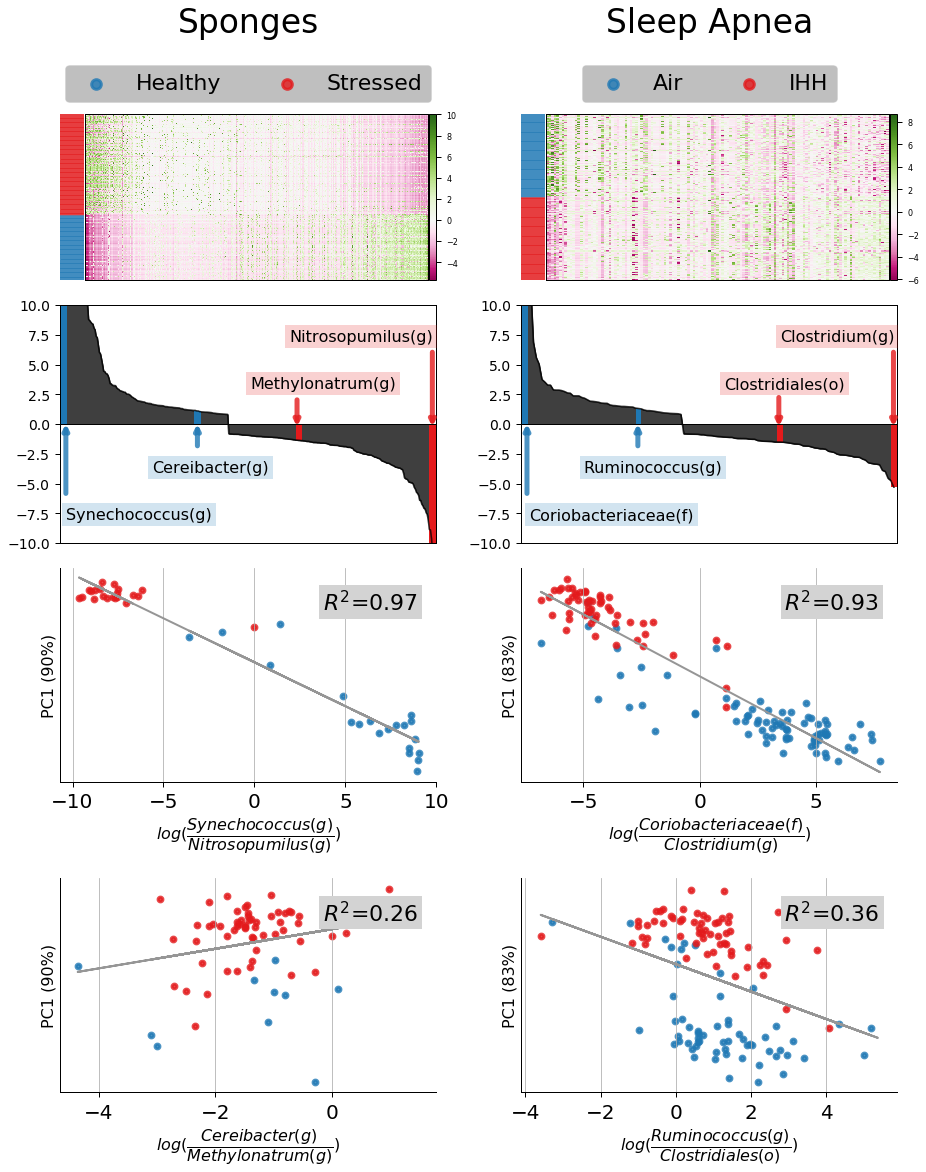

In [116]:
plt.rcParams["axes.labelsize"] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
colors_map=['#1f78b4','#e31a1c']
subpath_sp='sub_sample/biom_tables_Sponges'
subpath_sl='sub_sample/biom_tables_Sleep_Apnea'

fontsize_ = 18

fig = plt.figure(figsize=(15, 18), facecolor='white')
gs = gridspec.GridSpec(205, 100)

#biplots
ax1 = plt.subplot(gs[95:140, :45])
ax2 = plt.subplot(gs[95:140, 55:])
ax3 = plt.subplot(gs[160:, :45])
ax4 = plt.subplot(gs[160:, 55:])
# heatmaps
ax9 = plt.subplot(gs[:35, 3:44])
ax11 = plt.subplot(gs[:35, 58:99])
# heatmap bars
ax10 = plt.subplot(gs[:35, :3])
ax12 = plt.subplot(gs[:35, 55:58])
# heat map color bars
ax7 = plt.subplot(gs[:35, 44:45])
ax8 = plt.subplot(gs[:35, 99:100])
# rankings
ax5 = plt.subplot(gs[40:90, :45])
ax6 = plt.subplot(gs[40:90, 55:])

# iterating variables 
axn=[ax1,ax2,ax3,ax4]
axbar=[ax5,ax6,ax5,ax6]
axmap=[ax9,ax11,ax9,ax1]
axmapbar=[ax10,ax12,ax10,ax12]
axmacbar=[ax7,ax8,ax7,ax8]
regcolor=['#969696','#969696','#969696','#969696']
dtst=['Sponges','Sleep_Apnea',
      'Sponges','Sleep_Apnea']
lrs=['log(\\dfrac{Synechococcophycideae( c)_{ID:sOTU984}}{Nitrosopumilus( g)_{ID:sOTU14}})',
     'log(\\dfrac{Coriobacteriaceae( f)_{ID:sOTU258}}{Clostridium( g)_{ID:sOTU133}})',
    'log(\\dfrac{Bacteria(k)_{ID:sOTU1224}}{A4b( f)_{ID:sOTU30}})',
    'log(\\dfrac{Ruminococcus( g)_{ID:sOTU124}}{Clostridiales( o)_{ID:sOTU256}})']
ys=[0,1,0,1]
text_loc=[[(.21,.1),(.8,.85)], 
          [(.24,.1),(.84,.85)],
          [(.40,.3),(.7,.65)],
          [(.35,.3),(.7,.65)]] 

arrow_loc=[[(0.015,.2),(.99,.81)], 
          [(0.015,.2),(.99,.81)],
          [(.365,.4),(.63,.61)],
          [(.31,.4),(.685,.62)]] 

for (count_,ax_),dataset_,lr_,y_tmp,x_,X_arrow in zip(enumerate(axn), 
                                              dtst,lrs,ys,text_loc,arrow_loc):
    
    logdf_tmp=lr_datasets[dataset_]['lr']
    factor_=factor[dataset_]
    _,cmap_out=plot_biplot(logdf_tmp,  logdf_tmp, 
                ax_, factor_, lr_, y_tmp, regcolor[count_])
    ax_.set_ylabel('PC1 ('+str(int(lr_datasets[dataset_]['prop_var_exp']))+'%)',fontsize=16)  
    
    
    #r^2
    logdf_tmp_p=logdf_tmp.dropna(subset=[lr_,y_tmp])
    r_=pearsonr(logdf_tmp_p[lr_].values,logdf_tmp_p[y_tmp].values)
    r_=np.around(r_[0],2)
    ax_.annotate('$R^{2}$='+str(abs(r_)),(.7,.80), 
                 xycoords='axes fraction',
                 fontsize=22,bbox=dict(facecolor='lightgray',
                                       edgecolor='None',alpha=1.0))
    #fix axis
    
    
    
    X_1=lr_.split('{')[2].replace('}','').replace('ID:','')
    Y_1=lr_.split('{')[4].replace('}','').replace('ID:','').replace(')','')
    lr_title_=lr_.replace(X_1,'').replace(Y_1,'').replace('_{ID:}','').replace(' ','').replace('Bacteria(k)','Cereibacter(g)').replace('A4b(f)','Methylonatrum(g)').replace('Synechococcophycideae(c)','Synechococcus(g)')   
    X_1_sp=lr_title_.split('{')[1].replace('}','').replace('Bacteria(k)','Cereibacter(g)').replace('Synechococcophycideae(c)','Synechococcus(g)')
    Y_1_sp=lr_title_.split('{')[2].replace('})','').replace('A4b(f)','Methylonatrum(g)')
    #'sOTU1224'->'Cereibacter(g)' by blast
    #'sOTU30'->'Methylonatrum(g)' by blast
    
    ax_.set_xlabel('$'+lr_title_+'$',fontsize=16)
    
    
    ## barplot
    axbar_=axbar[count_] #bar
    fltmp=lr_datasets[dataset_]['fl_sub'].sort_values(y_tmp,ascending=False)
    fltmp=fltmp[abs(fltmp[y_tmp])>0.8]
    ind = np.arange(fltmp.shape[0])
    nxy_=list(fltmp[~fltmp.index.isin([X_1,Y_1])].index)
    fltmp_bars=fltmp.copy()
    fltmp_bars.loc[nxy_,y_tmp]=0
    fltmp_bars['group']=((fltmp_bars[y_tmp]<0).astype(int)*-1)+(fltmp_bars[y_tmp]>0).astype(int)
    colorsmap={0:'#a6cee3',1:'#1f78b4',-1:'#e41a1c'}
    fltmp_bars[y_tmp].plot(kind='bar',color=list(fltmp_bars['group'].map(colorsmap))
                           ,width=int(len(fltmp_bars)/100)*2,
                           ax=axbar_)
    axbar_.annotate(X_1_sp,
                    x_[0],
                   fontsize=16, ha='center',
                    xycoords='axes fraction',
                    bbox=dict(facecolor='#1f78b4',
                                       edgecolor='None',alpha=.2))
    
    axbar_.annotate('', xy=X_arrow[0], xycoords='axes fraction',
                    ha='center', xytext=(X_arrow[0][0],0.51), 
            arrowprops=dict(arrowstyle="<-", color='#1f78b4', lw=5,alpha=.8))
    
    
    axbar_.annotate(Y_1_sp,
                    x_[1],
                   fontsize=16, ha='center',
                    xycoords='axes fraction',
                    bbox=dict(facecolor='#e41a1c',
                                       edgecolor='None',alpha=.2))

    axbar_.annotate('', xy=X_arrow[1], xycoords='axes fraction',
                    ha='center', xytext=(X_arrow[1][0],0.48), 
            arrowprops=dict(arrowstyle="<-", color='#e41a1c', lw=5,alpha=.8))
    
    
    color_map_con = cm.Greys(np.linspace(0,1,len(fltmp)))
    fltmp[y_tmp].plot(kind='area',color='black',stacked=False,ax=axbar_)
    axbar_.axhline(0,c='black',lw=1,ls='-')
    axbar_.set_ylim(-10, 10)
    axbar_.set_xticks([])
    
    if count_ in [0,1]:
        ax_.legend(loc='upper center', 
                bbox_to_anchor=(0.5, 3.4),
                prop={'size':22},
                fancybox=True, framealpha=0.5,ncol=2
                , markerscale=2, facecolor="grey")
        
        # set titles for case-study 
        ax_.annotate(dataset_.replace('_',' '),(0.5,3.5), 
                           annotation_clip=False,ha='center',
                           xycoords='axes fraction',
                          fontsize=33)
        
        # plot map
        colors_map=['#1f78b4','#e31a1c']
        table_tmp=lr_datasets[dataset_]['table_sub'].copy()
        sort_meta=lr_datasets[dataset_]['meta_sub'][factor[dataset_]].sort_values()
        sorted_df = table_tmp.reindex(index=sort_meta.index, columns=fltmp.index)
        sorted_df = sorted_df.loc[:, sorted_df.sum(axis=0) > 10] #make clusters more evident 
        img = axmap[count_].imshow(clr(centralize(sorted_df+1)), aspect='auto', 
                            norm=MidpointNormalize(midpoint=0.),
                            interpolation='nearest', cmap='PiYG')
        axmap[count_].set_xticks([])
        axmap[count_].set_yticks([])
        
        # add color bar 
        fig.colorbar(img, cax=axmacbar[count_])
        axmacbar[count_].tick_params(labelsize=8) 


        # color map-bars
        unique_values = sorted(set(sort_meta.values)) 
        colors_map=list(cmap_out.values())
        vmap = { c : i for i, c in enumerate(unique_values) }
        mapper = lambda t: vmap[str(t)]
        cmap_object = mcolors.LinearSegmentedColormap.from_list('custom', colors_map, N=len(colors_map))
        sns.heatmap(pd.DataFrame(sort_meta).applymap(mapper), 
                    cmap=cmap_object,ax=axmapbar[count_],
                    yticklabels=False,xticklabels=False,cbar=False,alpha=.6)
        axmapbar[count_].set_xlabel('')
        axmapbar[count_].set_ylabel('')

fig.savefig('figures/figure5.png',dpi=300, 
            bbox_inches='tight',facecolor='white')
plt.show()